This training run is done on the new dataset with 1830 airfoils, 1 mach #, 25 AoA #s, and 3 Re #s.

It runs on the redefined NIF model.

In [3]:
%load_ext autoreload
%autoreload 2

# Define autroreload so that it doesn't cause pain in the ass when we change the functions and run this notebook

In [4]:
# Import all the models, training functions, manipulators here

# Define the relative paths, append it to the system path
import sys
from pathlib import Path
project_root = Path.cwd().resolve().parents[4]
github_root = Path.cwd().resolve().parents[3]
sys.path.append(str(project_root))
sys.path.append(str(github_root))

print(project_root)
print(github_root)

# Import shenanigans
from defs.helper_functions.training_functions import *
from defs.helper_functions.data_loaders import *
from defs.models.NIF import *

# Time, to precisely: time
import time

C:\SenkDosya\Projects\AeroML
C:\SenkDosya\Projects\AeroML\initial-project


In [5]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")  # Force CPU for testing purposes
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Figure out the data
df = pd.read_csv(rf"C:\SenkDosya\Projects\AeroML\airfoil_data\airfoil_dataset_8bern.csv")

df = df.drop(['N1', 'N2'], axis=1) # Remove N1 and N2 since all the airfoils are subsonic

geom, cond, perf, names= get_dataset(df, loc_geometry=[1,20], loc_cond=[21,23], loc_perf_coeffs=[24,26], loc_names=0) # Get the necessary stuff for the dataset
print(df.shape); print(geom.shape); print(cond.shape); print(perf.shape); print(len(names))

ds = AirfoilDataset(geom, cond, perf, names)

del df, geom, cond, perf, names # Delete these to preserve memory

cfg_loader = {
    'n_epoch': 100,
    'n_train': 1000,
    'n_test': 17250,
    'train_batch': 1
}

dl_train, dl_val, dl_test = get_dataloaders(ds=ds, cfg_loader=cfg_loader)


(137250, 27)
torch.Size([137250, 20])
torch.Size([137250, 3])
torch.Size([137250, 3])
137250


In [7]:
import torch.nn as nn

# Define the model and optimizer

cfg_shape_net = {
    'input_dim': 20,
    'output_dim': 3,
    'hidden_units': [2048,2048,2048,2048,2048],
    'shape_activation': nn.SELU
}

cfg_param_net = {
    'input_dim': 3,
    'hidden_units': [512,512,512],
    'param_activation': nn.Tanh
}

model = NIF_Pointwise(cfg_shape_net=cfg_shape_net, cfg_param_net=cfg_param_net)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

model = model.to(device)

# Define the loss_fn

loss_fn = nn.MSELoss()

In [33]:
# Show the model

from torchviz import make_dot

# Create and move inputs to device
show_tensor_1 = torch.randn(5, cfg_shape_net['input_dim']).to(device)
show_tensor_2 = torch.randn(5, cfg_param_net['input_dim']).to(device)

# Forward pass
output = model(show_tensor_1, show_tensor_2)

make_dot(output, params=dict(model.named_parameters())).render("model_graph_pairnif", format="png")

'model_graph_pairnif.png'

In [9]:
# Train the model

# Define the configs of train
cfg_train = {
    'cfg_loader': cfg_loader,
    'dtype': torch.float32,
    'device': device
}

dataloaders = [dl_train, dl_val, dl_test]


collector_dict, model = train(cfg_train=cfg_train, model=model, optimizer=optimizer, loss_fn=loss_fn, dataloaders=dataloaders)

Epoch 1 | Train run 1 loss: 0.37111926078796387
Epoch 1 | Train run 2 loss: 1.5587034225463867
Epoch 1 | Train run 3 loss: 0.6908996105194092
Epoch 1 | Train run 4 loss: 1.5765063762664795
Epoch 1 | Train run 5 loss: 1.1050899028778076
Epoch 1 | Train run 6 loss: 0.013546048663556576
Epoch 1 | Train run 7 loss: 1.2574565410614014
Epoch 1 | Train run 8 loss: 0.03037356398999691
Epoch 1 | Train run 9 loss: 0.01259575318545103
Epoch 1 | Train run 10 loss: 0.9071342945098877
Epoch 1 | Train run 11 loss: 0.5096726417541504
Epoch 1 | Train run 12 loss: 1.3509094715118408
Epoch 1 | Train run 13 loss: 0.17341026663780212
Epoch 1 | Train run 14 loss: 0.0692145898938179
Epoch 1 | Train run 15 loss: 0.467753529548645
Epoch 1 | Train run 16 loss: 1.4006295204162598
Epoch 1 | Train run 17 loss: 0.37671393156051636
Epoch 1 | Train run 18 loss: 0.08777844160795212
Epoch 1 | Train run 19 loss: 0.04976433143019676
Epoch 1 | Train run 20 loss: 0.9133225679397583
Epoch 1 | Train run 21 loss: 1.0025486946

torch.Size([100000])
100000


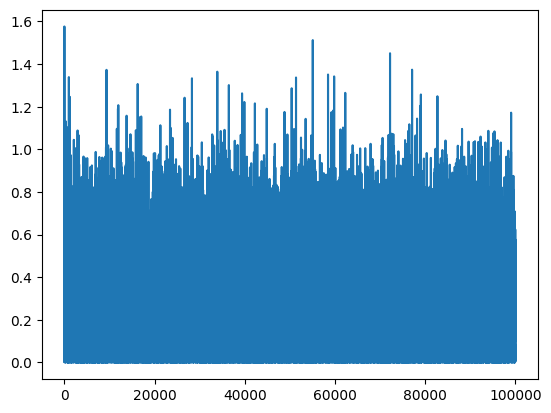

In [10]:
print(collector_dict['losses']['train'].shape)
import numpy as np


train_losses = collector_dict['losses']['train'].numpy()
index= np.arange(100000)

print(train_losses.size)

import matplotlib.pyplot as plt

plt.plot(index, train_losses, )
plt.show()

[0.17194039 0.24486639 0.17061391 0.16962394 0.16384862 0.16644067
 0.17322245 0.19247057 0.16015057 0.19180967 0.17558452 0.16466768
 0.16638103 0.1529401  0.16582444 0.17466404 0.17796119 0.17746472
 0.17007226 0.1566084  0.15444529 0.1540874  0.1817537  0.16972749
 0.14665157 0.16529252 0.17986463 0.17194867 0.18824877 0.17576946
 0.15923429 0.1994648  0.17379022 0.14378332 0.1657501  0.16857247
 0.15473126 0.13885498 0.15925659 0.1538648  0.15778501 0.14299193
 0.15194024 0.16512012 0.16470844 0.1477271  0.16228348 0.170542
 0.20626701 0.18662962 0.16514085 0.15279907 0.14152476 0.16167843
 0.18989779 0.16148476 0.18299302 0.14786784 0.16693878 0.15571213
 0.16215345 0.15462784 0.16967519 0.14673178 0.17361605 0.18851463
 0.17480648 0.18177137 0.14779505 0.16405912 0.210242   0.1684892
 0.15377188 0.16509974 0.16466057 0.1632008  0.15198912 0.15228117
 0.17959239 0.17980799 0.16704    0.15143919 0.15473402 0.1578468
 0.18755192 0.15298134 0.17528199 0.17285044 0.18838982 0.19308165

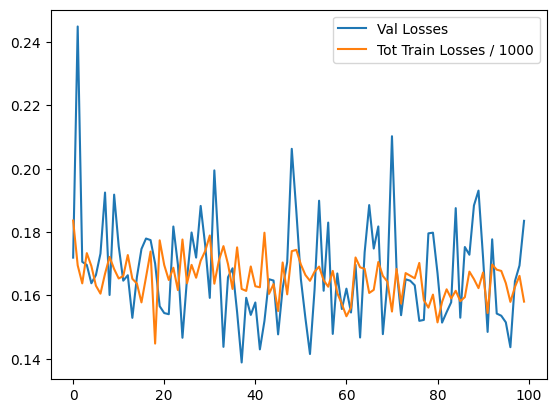

In [11]:
tot_train_losses = collector_dict['losses']['total_train'].numpy()/1000
val_losses = collector_dict['losses']['val'].numpy()

print(val_losses)
index = np.arange(100)

plt.plot(index, val_losses, label='Val Losses')
plt.plot(index, tot_train_losses, label= 'Tot Train Losses / 1000')
plt.legend()
plt.show()


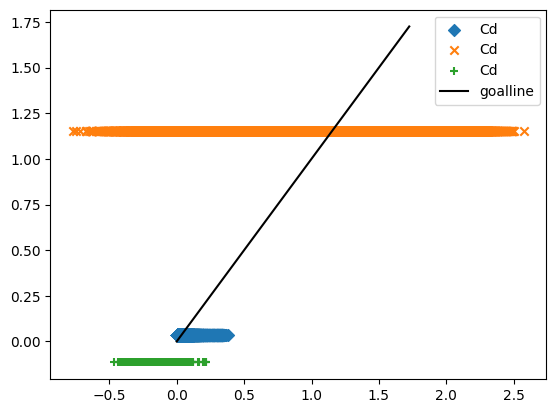

In [31]:
plt.scatter(collector_dict['actual']['test'][:,0].cpu().numpy(), collector_dict['preds']['test'][:,0].cpu().numpy(), marker='D', label= 'Cd')
plt.scatter(collector_dict['actual']['test'][:,1].cpu().numpy(), collector_dict['preds']['test'][:,1].cpu().numpy(), marker='x', label= 'Cd')
plt.scatter(collector_dict['actual']['test'][:,2].cpu().numpy(), collector_dict['preds']['test'][:,2].cpu().numpy(), marker='+', label= 'Cd')
plt.plot(np.arange(17250)/10000, np.arange(17250)/10000, color='k', label='goalline')
plt.legend()
plt.show()


Conclusion: We have insane model collapse.